In [15]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_ocr
import math
from PIL import Image, ImageFont, ImageDraw
from PIL import ImageFont
from pathlib import Path
from difflib import SequenceMatcher

In [16]:
df = pd.read_csv("movies_val_years.csv")
images_path = Path("raw_data/photos/movies_val_resized/")

In [17]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/jamie/.keras-ocr/craft_mlt_25k.h5
Looking for /home/jamie/.keras-ocr/crnn_kurapan.h5


In [18]:
def process_image_and_inpaint(image_path, pipeline):
    img = keras_ocr.tools.read(image_path)

    prediction_groups = pipeline.recognize([img])

    texts = []
    bboxes = []

    for result in prediction_groups[0]:
        texts.append(result[0])
        bboxes.append(result[1])

    text_df = pd.DataFrame({'text': texts, 'bbox': bboxes})

    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1]
        x2, y2 = box[1][2]
        x3, y3 = box[1][3]

        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mid1 = midpoint(x0, y0, x3, y3)

        thickness = int(math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))

        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mid1), 255, thickness)
        inpainted_img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)

    return text_df, inpainted_img

In [302]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2) / 2)
    y_mid = int((y1 + y2) / 2)
    return (x_mid, y_mid)

In [303]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

raw_data/photos/movies_val_resized/tt1825712.jpg


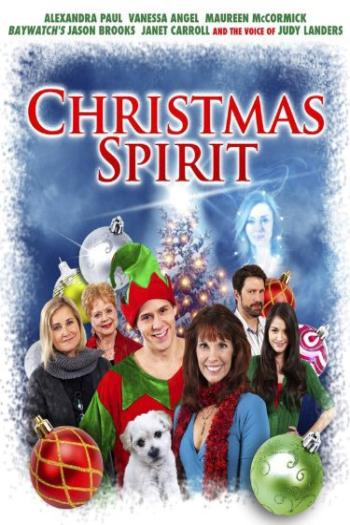

In [413]:
image_to_process = images_path / (df.imdbID[487] +".jpg")

# open method used to open different extension image file
im = Image.open(image_to_process)
print(image_to_process)

im

1/1 [==============================] - 1s 877ms/step
         text                                               bbox
0   alexandra  [[43.0, 12.0], [98.0, 12.0], [98.0, 24.0], [43...
1        paul  [[99.0, 12.0], [124.0, 12.0], [124.0, 23.0], [...
2     vanessa  [[127.0, 12.0], [168.0, 12.0], [168.0, 23.0], ...
3       angel  [[170.0, 12.0], [200.0, 12.0], [200.0, 23.0], ...
4     maureen  [[205.0, 12.0], [250.0, 12.0], [250.0, 23.0], ...
5   mccormick  [[251.0, 11.999999], [308.0, 12.0], [308.0, 22...
6   baywatcns  [[7.0, 23.999996], [65.99999, 23.999996], [65....
7        ason  [[66.0, 24.0], [97.0, 24.0], [97.0, 37.0], [66...
8      brooks  [[98.0, 24.0], [138.0, 24.0], [138.0, 37.0], [...
9       janet  [[141.0, 25.0], [169.0, 25.0], [169.0, 36.0], ...
10    carroll  [[170.0, 25.0], [212.0, 25.0], [212.0, 37.0], ...
11       judy  [[277.0, 25.0], [302.0, 25.0], [302.0, 37.0], ...
12    landers  [[303.0, 25.0], [345.0, 25.0], [345.0, 36.0], ...
13        and  [[212.0, 26.0], [228.0

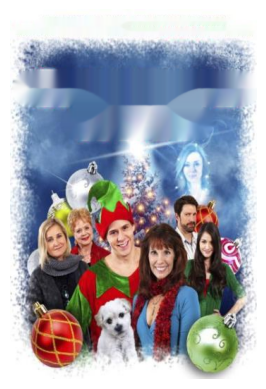

True

In [414]:
title = "christmas spirit"
actors = "alexandra paul vanessa angel maureen mccormick jason brooks janet carroll"

title_words = title.split()
actors_words = actors.split()

text_df, img_text_removed = process_image_and_inpaint(str(image_to_process), pipeline)
print(text_df)

plt.imshow(img_text_removed)  # No need to convert to RGB here
plt.axis('off')
plt.show()

cv2.imwrite('text_removed5.jpg', img_text_removed)

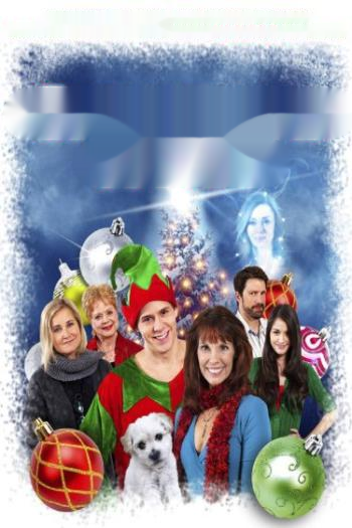

In [419]:
# Convert np array back to image
def np_to_arr(np_image):
  # All images are
  height = 525
  weight = 350
  channel = 3
  img_numpy = np.zeros((height, weight, channel), dtype=np.uint8)
  img = Image.fromarray(img_text_removed, "RGB")

  return img

image = np_to_arr(img_text_removed)

# Resize image as Stable Diffusion needs an image %8, Org:525, 350
init_image = image.resize((352, 528))
init_image

In [420]:
def words_location(text, text_df):
    
    text_list = text.lower().split()
    bbox_text = []
    
    for text_word in text_list:
        if text_word in list(text_df.text):
            bbox_text.append([x.round() for x in text_df[text_df.text == text_word].bbox][0])
        else :
            for word in list(text_df.text):
                if similar(text_word,word) > .8:
                    bbox_text.append([x.round() for x in text_df[text_df.text == word].bbox][0])
                    pass
                
    return text_list, bbox_text

title_words, title_location = words_location(title, text_df)

actor_words, actor_location = words_location(actors, text_df)

print(title_words)
print(title_location)
print("Words Found: ", len(title_location))
print(actor_words, actor_location, "Words Found: ", len(actor_location))

['christmas', 'spirit']
[array([[ 28.,  87.],
       [330.,  87.],
       [330., 137.],
       [ 28., 137.]], dtype=float32), array([[ 97., 137.],
       [264., 137.],
       [264., 185.],
       [ 97., 185.]], dtype=float32)]
Words Found:  2
['alexandra', 'paul', 'vanessa', 'angel', 'maureen', 'mccormick', 'jason', 'brooks', 'janet', 'carroll'] [array([[43., 12.],
       [98., 12.],
       [98., 24.],
       [43., 24.]], dtype=float32), array([[ 99.,  12.],
       [124.,  12.],
       [124.,  23.],
       [ 99.,  23.]], dtype=float32), array([[127.,  12.],
       [168.,  12.],
       [168.,  23.],
       [127.,  23.]], dtype=float32), array([[170.,  12.],
       [200.,  12.],
       [200.,  23.],
       [170.,  23.]], dtype=float32), array([[205.,  12.],
       [250.,  12.],
       [250.,  23.],
       [205.,  23.]], dtype=float32), array([[251.,  12.],
       [308.,  12.],
       [308.,  23.],
       [251.,  23.]], dtype=float32), array([[66., 24.],
       [97., 24.],
       [97., 37

<class 'PIL.Image.Image'>


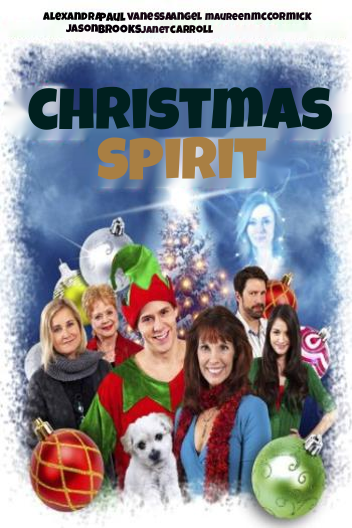

In [423]:
# Open the desired Image you want to add text on
print(type(init_image))
cur_image = init_image

# To add 2D graphics in an image call draw Method
Im = ImageDraw.Draw(cur_image)

def print_words(text_list, bbox_text):
    for i, bbox in enumerate(bbox_text): 
        a, b, = bbox[0]
        text = text_list[i]
        font = ImageFont.truetype("raw_data/font_files/LuckiestGuy-Regular.ttf", 1)
        font_len = 0
        font_size = 1
        
        # Making font bigger until text is the same size as before
        while font_len < (bbox[1][0] - bbox[0][0]):
            font = ImageFont.truetype("raw_data/font_files/LuckiestGuy-Regular.ttf", 1+font_size)
            font_size = font_size + 1
            font_len = font.getlength(text)
        
        # Making sure the colour is different from the background
        cor_left = min(bbox[0][0].round(), bbox[2][0].round())
        cor_upper= min(bbox[0][1].round(), bbox[2][1].round())
        cor_right = max(bbox[0][0].round(), bbox[2][0].round())
        cor_lower= max(bbox[0][1].round(), bbox[2][1].round())
        
        #cor = np.concatenate((cor_left,cor_upper,cor_right,cor_lower), axis=0)
        crop_img = im.crop((cor_left, cor_upper, cor_right, cor_lower))
        most_common = sorted(crop_img.getcolors(maxcolors=2**16), key=lambda t: t[0], reverse=True)[0]  
        fill=(255-most_common[1][0], 255-most_common[1][1], 255-most_common[1][2])

        Im.text((a, b), text=text, font=font , fill=fill)

print_words(title_words, title_location)
print_words(actor_words, actor_location)

cur_image